In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from timm import create_model
from timm.loss import LabelSmoothingCrossEntropy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import seaborn as sns

In [2]:
PATH = '/media/user/9C33-6BBD/data_PCNSL_sel/'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
torch.manual_seed(1234) 

In [179]:
batch_size = 10

transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.RandomAutocontrast(),
    #transforms.TrivialAugmentWide(),                        
    #transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = datasets.ImageFolder(root=PATH+'train', transform = transform_train)
# augment batch_size to 64, for example                                        
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True, num_workers=8,pin_memory=True)
                                       
test_data = datasets.ImageFolder(root=PATH+'test', transform = transform_test)

# augment batch_size to 64, for example    
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=False, num_workers=8,pin_memory=True)


In [45]:
batch_size = 10

classes = ['Cluster1', 'Cluster2', 'Cluster3', 'Cluster4']

model = create_model("tf_efficientnetv2_s", pretrained=True)
num_ftrs = model.classifier.in_features

model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 4)
)
model.to(device)

criterion = LabelSmoothingCrossEntropy()
optimizer = optim.AdamW(model.parameters(), lr=0.00001, weight_decay=0.0001)


scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

train_losses = []
train_accs = []
test_losses = []
test_accs = []
best_loss = float('inf')
best_acc = 0

for epoch in range(50):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / (i+1)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss +=loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_loss = running_loss / len(testloader)
        test_acc = correct / total
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print('Epoch: {}  Train Loss: {:.3f}  Train Acc: {:.3f}  Test Loss: {:.3f}  Test Acc: {:.3f}'.format(
            epoch+1, train_loss,train_acc, test_loss, test_acc))

        # Save model if it improves loss and accuracy
        if test_loss < best_loss and test_acc > best_acc:
            torch.save(model.state_dict(), 'best_model_complete_transforms_batch10v2.pt')
            best_loss = test_loss
            best_acc = test_acc

        # Adjust learning rate
        scheduler.step(test_loss)

        # Early stopping if the validation loss does not improve
        if epoch > 10 and test_loss > max(test_losses[-5:]):
            print('Early stopping')
            break

Epoch: 1  Train Loss: 1.342  Train Acc: 0.386  Test Loss: 2.857  Test Acc: 0.490
Epoch: 2  Train Loss: 1.156  Train Acc: 0.528  Test Loss: 1.989  Test Acc: 0.521
Epoch: 3  Train Loss: 1.068  Train Acc: 0.588  Test Loss: 1.622  Test Acc: 0.576
Epoch: 4  Train Loss: 1.002  Train Acc: 0.635  Test Loss: 8.898  Test Acc: 0.618
Epoch: 5  Train Loss: 0.922  Train Acc: 0.689  Test Loss: 3.331  Test Acc: 0.600
Epoch: 6  Train Loss: 0.877  Train Acc: 0.718  Test Loss: 1.859  Test Acc: 0.649
Epoch: 7  Train Loss: 0.827  Train Acc: 0.754  Test Loss: 1.128  Test Acc: 0.664
Epoch: 8  Train Loss: 0.769  Train Acc: 0.785  Test Loss: 1.120  Test Acc: 0.676
Epoch: 9  Train Loss: 0.746  Train Acc: 0.800  Test Loss: 1.772  Test Acc: 0.687
Epoch: 10  Train Loss: 0.711  Train Acc: 0.821  Test Loss: 1.360  Test Acc: 0.709
Epoch: 11  Train Loss: 0.675  Train Acc: 0.841  Test Loss: 1.856  Test Acc: 0.706
Epoch: 12  Train Loss: 0.647  Train Acc: 0.857  Test Loss: 1.918  Test Acc: 0.689
Epoch: 13  Train Loss: 0.

In [85]:
from sklearn.metrics import classification_report


print(classification_report(y_true, y_pred, target_names=classes))

              precision    recall  f1-score   support

   Cluster 1       0.67      0.71      0.69       800
   Cluster 2       0.81      0.56      0.66       800
   Cluster 3       0.76      0.85      0.80       800
   Cluster 4       0.70      0.80      0.75       801

    accuracy                           0.73      3201
   macro avg       0.74      0.73      0.73      3201
weighted avg       0.74      0.73      0.73      3201



In [165]:
# from https://github.com/kazuto1011/grad-cam-pytorch/blob/master/grad_cam.py

#!/usr/bin/env python
# coding: utf-8
#
# Author:   Kazuto Nakashima
# URL:      http://kazuto1011.github.io
# Created:  2017-05-26

from collections import Sequence

import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm


class _BaseWrapper(object):
    def __init__(self, model):
        super(_BaseWrapper, self).__init__()
        self.device = next(model.parameters()).device
        self.model = model
        self.handlers = []  # a set of hook function handlers

    def _encode_one_hot(self, ids):
        one_hot = torch.zeros_like(self.logits).to(self.device)
        one_hot.scatter_(1, ids, 1.0)
        return one_hot

    def forward(self, image):
        self.image_shape = image.shape[2:]
        self.logits = self.model(image)
        self.probs = F.softmax(self.logits, dim=1)
        return self.probs.sort(dim=1, descending=True)  # ordered results

    def backward(self, ids):
        """
        Class-specific backpropagation
        """
        one_hot = self._encode_one_hot(ids)
        self.model.zero_grad()
        self.logits.backward(gradient=one_hot, retain_graph=True)

    def generate(self):
        raise NotImplementedError

    def remove_hook(self):
        """
        Remove all the forward/backward hook functions
        """
        for handle in self.handlers:
            handle.remove()


class BackPropagation(_BaseWrapper):
    def forward(self, image):
        self.image = image.requires_grad_()
        return super(BackPropagation, self).forward(self.image)

    def generate(self):
        gradient = self.image.grad.clone()
        self.image.grad.zero_()
        return gradient


class GuidedBackPropagation(BackPropagation):
    """
    "Striving for Simplicity: the All Convolutional Net"
    https://arxiv.org/pdf/1412.6806.pdf
    Look at Figure 1 on page 8.
    """

    def __init__(self, model):
        super(GuidedBackPropagation, self).__init__(model)

        def backward_hook(module, grad_in, grad_out):
            # Cut off negative gradients
            if isinstance(module, nn.ReLU):
                return (F.relu(grad_in[0]),)

        for module in self.model.named_modules():
            self.handlers.append(module[1].register_backward_hook(backward_hook))


class Deconvnet(BackPropagation):
    """
    "Striving for Simplicity: the All Convolutional Net"
    https://arxiv.org/pdf/1412.6806.pdf
    Look at Figure 1 on page 8.
    """

    def __init__(self, model):
        super(Deconvnet, self).__init__(model)

        def backward_hook(module, grad_in, grad_out):
            # Cut off negative gradients and ignore ReLU
            if isinstance(module, nn.ReLU):
                return (F.relu(grad_out[0]),)

        for module in self.model.named_modules():
            self.handlers.append(module[1].register_backward_hook(backward_hook))


class GradCAM(_BaseWrapper):
    """
    "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"
    https://arxiv.org/pdf/1610.02391.pdf
    Look at Figure 2 on page 4
    """

    def __init__(self, model, candidate_layers=None):
        super(GradCAM, self).__init__(model)
        self.fmap_pool = {}
        self.grad_pool = {}
        self.candidate_layers = candidate_layers  # list

        def save_fmaps(key):
            def forward_hook(module, input, output):
                self.fmap_pool[key] = output.detach()

            return forward_hook

        def save_grads(key):
            def backward_hook(module, grad_in, grad_out):
                self.grad_pool[key] = grad_out[0].detach()

            return backward_hook

        # If any candidates are not specified, the hook is registered to all the layers.
        for name, module in self.model.named_modules():
            if self.candidate_layers is None or name in self.candidate_layers:
                self.handlers.append(module.register_forward_hook(save_fmaps(name)))
                self.handlers.append(module.register_backward_hook(save_grads(name)))

    def _find(self, pool, target_layer):
        if target_layer in pool.keys():
            return pool[target_layer]
        else:
            raise ValueError("Invalid layer name: {}".format(target_layer))

    def generate(self, target_layer):
        fmaps = self._find(self.fmap_pool, target_layer)
        grads = self._find(self.grad_pool, target_layer)
        weights = F.adaptive_avg_pool2d(grads, 1)

        gcam = torch.mul(fmaps, weights).sum(dim=1, keepdim=True)
        gcam = F.relu(gcam)
        gcam = F.interpolate(
            gcam, self.image_shape, mode="bilinear", align_corners=False
        )

        B, C, H, W = gcam.shape
        gcam = gcam.view(B, -1)
        gcam -= gcam.min(dim=1, keepdim=True)[0]
        gcam /= gcam.max(dim=1, keepdim=True)[0]
        gcam = gcam.view(B, C, H, W)

        return gcam


def occlusion_sensitivity(
    model, images, ids, mean=None, patch=35, stride=1, n_batches=128
):
    """
    "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"
    https://arxiv.org/pdf/1610.02391.pdf
    Look at Figure A5 on page 17

    Originally proposed in:
    "Visualizing and Understanding Convolutional Networks"
    https://arxiv.org/abs/1311.2901
    """

    torch.set_grad_enabled(False)
    model.eval()
    mean = mean if mean else 0
    patch_H, patch_W = patch if isinstance(patch, Sequence) else (patch, patch)
    pad_H, pad_W = patch_H // 2, patch_W // 2

    # Padded image
    images = F.pad(images, (pad_W, pad_W, pad_H, pad_H), value=mean)
    B, _, H, W = images.shape
    new_H = (H - patch_H) // stride + 1
    new_W = (W - patch_W) // stride + 1

    # Prepare sampling grids
    anchors = []
    grid_h = 0
    while grid_h <= H - patch_H:
        grid_w = 0
        while grid_w <= W - patch_W:
            grid_w += stride
            anchors.append((grid_h, grid_w))
        grid_h += stride

    # Baseline score without occlusion
    baseline = model(images).detach().gather(1, ids)

    # Compute per-pixel logits
    scoremaps = []
    for i in tqdm(range(0, len(anchors), n_batches), leave=False):
        batch_images = []
        batch_ids = []
        for grid_h, grid_w in anchors[i : i + n_batches]:
            images_ = images.clone()
            images_[..., grid_h : grid_h + patch_H, grid_w : grid_w + patch_W] = mean
            batch_images.append(images_)
            batch_ids.append(ids)
        batch_images = torch.cat(batch_images, dim=0)
        batch_ids = torch.cat(batch_ids, dim=0)
        scores = model(batch_images).detach().gather(1, batch_ids)
        scoremaps += list(torch.split(scores, B))

    diffmaps = torch.cat(scoremaps, dim=1) - baseline
    diffmaps = diffmaps.view(B, new_H, new_W)

    return diffmaps

/home/user/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  submodule in :meth:`~torch.nn.Module.state_dict`.


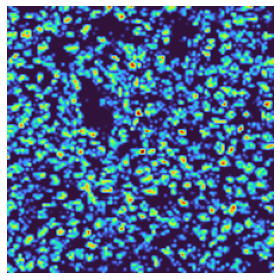

Predicted class 111


In [166]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import torch
from PIL import Image
from torchvision import transforms

def softmax(x):
    """ applies softmax to an input x"""
    e_x = np.exp(x)
    return e_x / e_x.sum()



if __name__ == "__main__":

    image_path = '/media/user/9C33-6BBD/data_PCNSL_sel/test/Cluster1/N0500355/N0500355_98.jpg'
    device = "cpu"

    # Model from torchvision
    target_layer = "bn1"
    my_model = create_model("tf_efficientnetv2_s", pretrained=True)
    my_model.to(device)
    my_model.eval()

    # Images
    image = Image.open(image_path)
    raw_image = np.asarray(image)
    image = transforms.Compose(
        [
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ]
    )(image)
    images = torch.stack([image]).to(device)

    gcam = GradCAM(model=my_model)
    _, sorted_ids = gcam.forward(images)
    ids_1st = sorted_ids[:, [0]]  # 'Cluster 1'
    #ids_6th = sorted_ids[:, [5]]  # 'tiger_cat'

    # 1st round for the Cluster 1

    gcam.backward(ids=ids_1st)
    heatmap = gcam.generate(target_layer=target_layer)
    heatmap = heatmap.cpu().numpy().squeeze()
    heatmap = cm.turbo(heatmap)[..., :3] * 255.0
    #heatmap = (heatmap.astype(np.float) + raw_image.astype(np.float)) / 2
    plt.imshow(np.uint8(heatmap))
    plt.axis('off'); plt.tight_layout()
    plt.show()

    #images = torch.stack([image]).to(device)

    predicted_class = np.argmax(softmax(my_model(image[None, ...]).detach().numpy()))
    print(f'Predicted class {predicted_class}')

    #gcam = GradCAM(model=my_model)
    #_, sorted_ids = gcam.forward(images)
    #ids_predicted = sorted_ids[:, [predicted_class]]

    #n_rows = len(model.blocks)//4 if len(model.blocks)%4==0 else len(model.blocks)//4+1
    #n_cols = 4

    #fig, ax = plt.subplots(n_rows, n_cols, figsize=(40,40))
    #gcam.backward(ids=ids_predicted)
    #layer = 5 
    #for row in range(n_rows):
    #    for col in range(n_cols):
    #        target_layer = f"blocks.{layer}"
    #        heatmap = gcam.generate(target_layer=target_layer)
    #        heatmap = heatmap.cpu().numpy().squeeze()
    #        heatmap = cm.turbo(heatmap)[..., :3] * 255.0
    #        #heatmap = (heatmap.astype(np.float) + raw_image.astype(np.float)) / 2
    #        ax[row,col].imshow(np.uint8(heatmap))
    #        ax[row,col].set_title(target_layer)
    #        if layer == len(model.modules)-1:
    #            break
    #        else:
    #            layer += 1

    #plt.show()


In [6]:
model.parameters

<bound method Module.parameters of EfficientNet(
  (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (drop_path): Identity()
      )
      (1): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (drop_path): Identity()
   

In [180]:
batch_size = 10

classes = ['Cluster1', 'Cluster2', 'Cluster3', 'Cluster4']

model = create_model("tf_efficientnetv2_s", pretrained=True)
num_ftrs = model.classifier.in_features

model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 4)
)
model.to(device)

criterion = LabelSmoothingCrossEntropy()
optimizer = optim.AdamW(model.parameters(), lr=0.00001, weight_decay=0.0001)


scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

train_losses = []
train_accs = []
test_losses = []
test_accs = []
best_loss = float('inf')
best_acc = 0

for epoch in range(50):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / (i+1)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss +=loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_loss = running_loss / len(testloader)
        test_acc = correct / total
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print('Epoch: {}  Train Loss: {:.3f}  Train Acc: {:.3f}  Test Loss: {:.3f}  Test Acc: {:.3f}'.format(
            epoch+1, train_loss,train_acc, test_loss, test_acc))

        # Save model if it improves loss and accuracy
        if test_loss < best_loss and test_acc > best_acc:
            torch.save(model.state_dict(), 'best_model_complete_transforms_batch10v3.pt')
            best_loss = test_loss
            best_acc = test_acc

        # Adjust learning rate
        scheduler.step(test_loss)

        # Early stopping if the validation loss does not improve
        if epoch > 10 and test_loss > max(test_losses[-5:]):
            print('Early stopping')
            break

Epoch: 1  Train Loss: 1.344  Train Acc: 0.373  Test Loss: 1.280  Test Acc: 0.449
Epoch: 2  Train Loss: 1.178  Train Acc: 0.517  Test Loss: 14.957  Test Acc: 0.494
Epoch: 3  Train Loss: 1.083  Train Acc: 0.582  Test Loss: 1.180  Test Acc: 0.571
Epoch: 4  Train Loss: 1.008  Train Acc: 0.630  Test Loss: 1.319  Test Acc: 0.595
Epoch: 5  Train Loss: 0.938  Train Acc: 0.676  Test Loss: 1.145  Test Acc: 0.615
Epoch: 6  Train Loss: 0.890  Train Acc: 0.711  Test Loss: 3.874  Test Acc: 0.637
Epoch: 7  Train Loss: 0.830  Train Acc: 0.743  Test Loss: 1.126  Test Acc: 0.670
Epoch: 8  Train Loss: 0.798  Train Acc: 0.767  Test Loss: 3.148  Test Acc: 0.641
Epoch: 9  Train Loss: 0.750  Train Acc: 0.793  Test Loss: 6.208  Test Acc: 0.660
Epoch: 10  Train Loss: 0.719  Train Acc: 0.812  Test Loss: 1.609  Test Acc: 0.668
Epoch: 11  Train Loss: 0.691  Train Acc: 0.837  Test Loss: 1.107  Test Acc: 0.672
Epoch: 12  Train Loss: 0.655  Train Acc: 0.852  Test Loss: 1.103  Test Acc: 0.674
Epoch: 13  Train Loss: 0

Confusion matrix:
[[566 118  63  53]
 [ 59 437 190 114]
 [ 64  25 662  49]
 [ 74  15  20 691]]


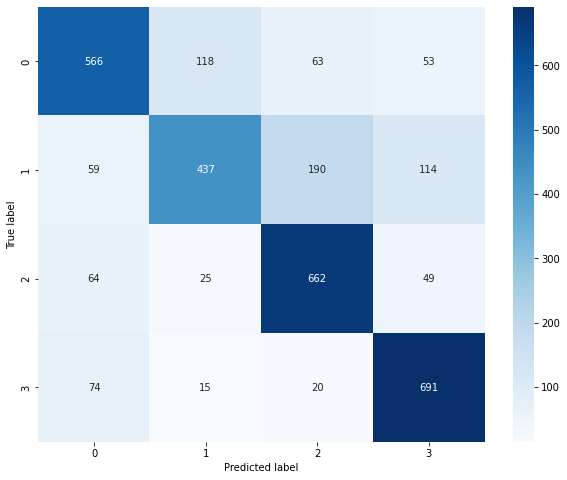

In [181]:
# Compute and print confusion matrix

num_classes = 4

y_pred = []
y_true = []
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
confusion = confusion_matrix(y_true, y_pred)
print('Confusion matrix:')
print(confusion)

# Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.savefig("confusion_matrix_batch10_transformv3.png")
plt.show()

In [183]:
from sklearn.metrics import classification_report


print(classification_report(y_true, y_pred, target_names=classes))

              precision    recall  f1-score   support

    Cluster1       0.74      0.71      0.72       800
    Cluster2       0.73      0.55      0.63       800
    Cluster3       0.71      0.83      0.76       800
    Cluster4       0.76      0.86      0.81       800

    accuracy                           0.74      3200
   macro avg       0.74      0.74      0.73      3200
weighted avg       0.74      0.74      0.73      3200



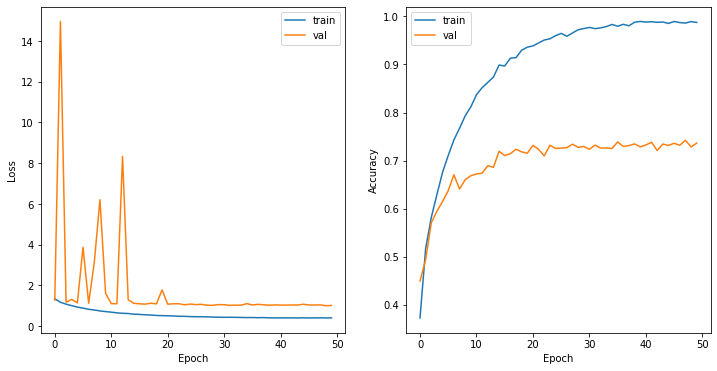

In [187]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='train')
plt.plot(test_accs, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy_loss_class_PCNSL_batch10_transformv3.png')
plt.show()

In [184]:
torch.save(model, 'model_batch10_transformv3.pth')

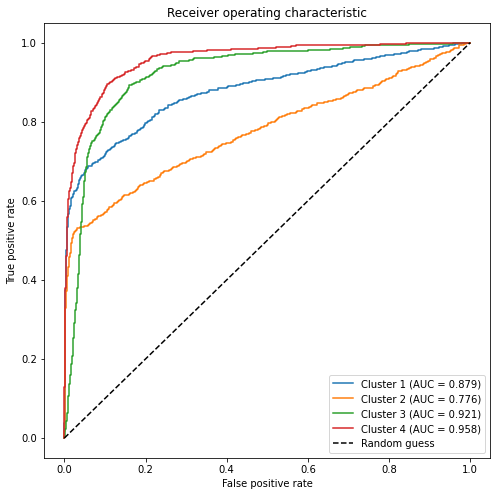

In [185]:
# Compute predicted probabilities for test set
model.eval()
y_true = np.array(test_data.targets)
y_scores = np.zeros((len(test_data), 4))
with torch.no_grad():
    for i, (inputs, _) in enumerate(testloader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_scores[i*10:(i+1)*10] = nn.functional.softmax(outputs, dim=1).cpu().numpy()

# Compute AUC curves and plot
classes = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']
plt.figure(figsize=(8, 8))
for i in range(4):
    fpr, tpr, thresholds = roc_curve((y_true == i).astype(int), y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{} (AUC = {:.3f})'.format(classes[i], roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver operating characteristic')
plt.legend()
plt.savefig('ROC_AUC_curves_PCNSL_batch10_transformv3.png')
plt.show()

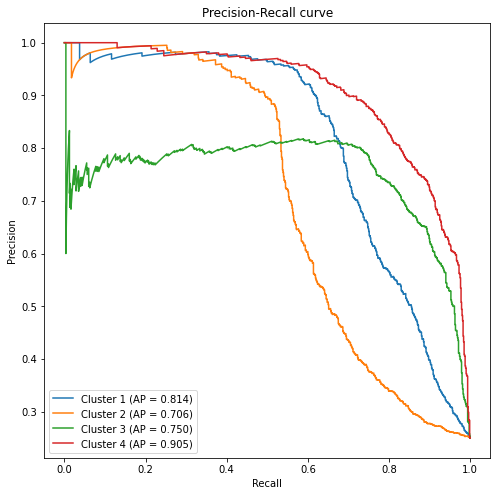

In [186]:
# Compute predicted probabilities for test set
model.eval()
y_true = np.array(test_data.targets)
y_scores = np.zeros((len(test_data), 4))
with torch.no_grad():
    for i, (inputs, _) in enumerate(testloader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_scores[i*10:(i+1)*10] = nn.functional.softmax(outputs, dim=1).cpu().numpy()

# Compute precision-recall curves and plot
classes = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']
plt.figure(figsize=(8, 8))
for i in range(4):
    precision, recall, thresholds = precision_recall_curve((y_true == i).astype(int), y_scores[:, i])
    avg_precision = average_precision_score((y_true == i).astype(int), y_scores[:, i])
    plt.plot(recall, precision, label='{} (AP = {:.3f})'.format(classes[i], avg_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.savefig('precision_recall_curves_PCNSL_batch10_transformv3.png')
plt.show()

In [188]:
# save training, evaluation and results

history = {'train_losses': train_losses, 'train_accs': train_accs, 'test_losses': test_losses, 'test_accs': test_accs}
results = {'test_loss': test_loss, 'test_acc': test_acc}
torch.save(history, 'training_history_batch10_transformv3.pt')
torch.save(results, 'evaluation_results_batch10_transformv3.pt')